In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import os      #We write a program that will run on both Windows and GNU/Linux.
import glob    #For useful easier file or extansion search
import cv2

In [2]:
def resize(path, img_height, img_width):
    img = cv2.imread(path)
    resized = cv2.resize(img, (img_height, img_width))# Every img converting to
    return resized                                    # 64x64 pixel 

In [3]:
def get_data():                    
    train_directory ="imgs/train/" # Data Directory
    X_train = []                   # For Train and Test we assign empty array.
    y_train = []
    
    for j in range(10):            # We'll pull the data sequentially from file.
        print("Load Folder c{}".format(j))
        path = os.path.join(train_directory, 'c' + str(j), '*.jpg') #c0, c1, c2 ...
        files = glob.glob(path)
        for fl in files:
            flbase = os.path.basename(fl) #Method is used to get 
                                          #the base name in specified path
            img = resize(fl, 64, 64)   # We convert the images to 64x64 size  
            X_train.append(img)  # And finally, we added the empty defined array.
            y_train.append(j)  # And then, for y_train set.
    return X_train, y_train

In [4]:
X_train, y = get_data()

Load Folder c0
Load Folder c1
Load Folder c2
Load Folder c3
Load Folder c4
Load Folder c5
Load Folder c6
Load Folder c7
Load Folder c8
Load Folder c9


In [5]:
X_train = np.asarray(X_train) # Convert the input to an array.
y = np.asarray(y)
print(X_train.shape), print(y.shape)

(22424, 64, 64, 3)
(22424,)


(None, None)

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y, test_size=0.25, random_state=42)
# Split arrays or matrices into random train and test subsets

In [7]:
#numpy.reshape(array, newshape, order='C')
#Gives a new shape to an array without changing its data
# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1)) # Same ID
X_val = np.reshape(X_val, (X_val.shape[0], -1))       # X_test
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)

Training data shape:  (16818, 12288)
Validation data shape:  (5606, 12288)


# K- Nearest Neighbor Algorithm

The kNN classifier consists of two stages:

    1.During training, the classifier takes the training data and simply remembers it
    2.During testing, kNN classifies every test image by comparing to all training images and transfering the labels of the k most similar training examples
    The value of k is cross-validated

In [8]:
from KNearestNeighbor import KNearestNeighbor

# Create a kNN classifier instance. 
# Remember that training a kNN classifier is a noop: 
# the Classifier simply remembers the data and does no further processing 
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)



We would now like to classify the test data with the kNN classifier. Recall that we can break down this process into two steps:

    1.First we must compute the distances between all test examples and all train examples.
    2.Given these distances, for each test example we find the k nearest examples and have them vote for the label

Lets begin with computing the distance matrix between all training and test examples. For example, if there are Ntr training examples and Nte test examples, this stage should result in a Nte x Ntr matrix where each element (i,j) is the distance between the i-th test and j-th train example.

First, open cs231n/classifiers/k_nearest_neighbor.py and implement the function compute_distances_two_loops that uses a (very inefficient) double loop over all pairs of (test, train) examples and computes the distance matrix one element at a time.


In [9]:
# compute_distances_two_loops.
# Test your implementation:
dists = classifier.compute_distances_two_loops(X_val)
print(dists.shape)

(5606, 16818)


In [20]:
# Now implement the function predict_labels and run the code below:
# We use k = 1 (which is Nearest Neighbor).
y_test_pred = classifier.predict_labels(dists, k=1)

# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == y_val)
num_test = X_val.shape[0]
accuracy = float(num_correct) / (num_test)
print('Got ',num_correct,' / ',num_test,' correct => accuracy: ',accuracy)

Got  5572  /  5606  correct => accuracy:  0.9939350695683197


In [30]:
num_training = 5000
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = range(num_test)
X_val = X_val[mask]
y_val = y_val[mask]

X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
print(X_train.shape, X_val.shape)

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

dists = classifier.compute_distances_two_loops(X_val)
print(dists.shape)

y_test_pred = classifier.predict_labels(dists, k=1)

# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == y_val)
num_test = X_val.shape[0]
accuracy = float(num_correct) / (num_test)
print('Got ',num_correct,' / ',num_test,' correct => accuracy: ',accuracy)

(5000, 12288) (500, 12288)
(500, 5000)
Got  481  /  500  correct => accuracy:  0.962


You should expect to see approximately 99% accuracy. Now lets try out a larger k, say k = 5:

In [41]:
y_test_pred = classifier.predict_labels(dists, k=5)
num_correct = np.sum(y_test_pred == y_val)
num_test = X_val.shape[0]
accuracy = float(num_correct) / num_test
print('Got ',num_correct,' / ',num_test,' correct => accuracy: ',accuracy)

Got  467  /  500  correct => accuracy:  0.934



# Cross-validation

We have implemented the k-Nearest Neighbor classifier but we set the value k = 5 arbitrarily. We will now determine the best value of this hyperparameter with cross-validation.


In [45]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = []
y_train_folds = []
################################################################################
# Split up the training data into folds. After splitting, X_train_folds and    #
# y_train_folds should each be lists of length num_folds, where                #
# y_train_folds[i] is the label vector for the points in X_train_folds[i].     #
# Hint: Look up the numpy array_split function.                                #
################################################################################

X_train_folds = np.array_split(X_train, num_folds, axis=0) # list
y_train_folds = np.array_split(y_train, num_folds, axis=0) # list

# A dictionary holding the accuracies for different values of k that we find
# when running cross-validation. After running cross-validation,
# k_to_accuracies[k] should be a list of length num_folds giving the different
# accuracy values that we found when using that value of k.
k_to_accuracies = {}


################################################################################
# TODO:                                                                        #
# Perform k-fold cross validation to find the best value of k. For each        #
# possible value of k, run the k-nearest-neighbor algorithm num_folds times,   #
# where in each case you use all but one of the folds as training data and the #
# last fold as a validation set. Store the accuracies for all fold and all     #
# values of k in the k_to_accuracies dictionary.                               #
################################################################################

for i in range(num_folds):
    # train / validation split (80% 20%)
    X_train_batch = np.concatenate(X_train_folds[1:num_folds])   
    y_train_batch = np.concatenate(y_train_folds[1:num_folds])
    X_valid_batch = X_train_folds[0]   
    y_valid_batch = y_train_folds[0]

    # swap data (for next iteration)
    if i < num_folds - 1:
        tmp = X_train_folds[0]
        X_train_folds[0] = X_train_folds[i+1]
        X_train_folds[i+1] = tmp
        tmp = y_train_folds[0]
        y_train_folds[0] = y_train_folds[i+1]
        y_train_folds[i+1] = tmp

    
    # train model
    model = KNearestNeighbor()
    model.train(X_train_batch, y_train_batch)
    dists = model.compute_distances_two_loops(X_valid_batch)
    
    # compute accuracy for each k 
    for k in k_choices:
        y_valid_pred = model.predict_labels(dists, k=k)

        # compute validation accuracy
        num_correct = np.sum(y_valid_pred == y_valid_batch)
        accuracy = float(num_correct) / y_valid_batch.shape[0]

        # accumulate accuracy into dictionary
        if i == 0:
            k_to_accuracies[k] = [] 
        k_to_accuracies[k].append(accuracy)

# Print out the computed accuracies
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = {:.3f}, accuracy = {:.3f}'.format(k, accuracy))

k = 1.000, accuracy = 0.977
k = 1.000, accuracy = 0.956
k = 1.000, accuracy = 0.965
k = 1.000, accuracy = 0.964
k = 1.000, accuracy = 0.973
k = 3.000, accuracy = 0.952
k = 3.000, accuracy = 0.939
k = 3.000, accuracy = 0.942
k = 3.000, accuracy = 0.942
k = 3.000, accuracy = 0.945
k = 5.000, accuracy = 0.935
k = 5.000, accuracy = 0.910
k = 5.000, accuracy = 0.927
k = 5.000, accuracy = 0.920
k = 5.000, accuracy = 0.920
k = 8.000, accuracy = 0.896
k = 8.000, accuracy = 0.863
k = 8.000, accuracy = 0.882
k = 8.000, accuracy = 0.890
k = 8.000, accuracy = 0.883
k = 10.000, accuracy = 0.872
k = 10.000, accuracy = 0.854
k = 10.000, accuracy = 0.864
k = 10.000, accuracy = 0.862
k = 10.000, accuracy = 0.863
k = 12.000, accuracy = 0.847
k = 12.000, accuracy = 0.832
k = 12.000, accuracy = 0.837
k = 12.000, accuracy = 0.846
k = 12.000, accuracy = 0.843
k = 15.000, accuracy = 0.811
k = 15.000, accuracy = 0.789
k = 15.000, accuracy = 0.806
k = 15.000, accuracy = 0.800
k = 15.000, accuracy = 0.808
k = 2

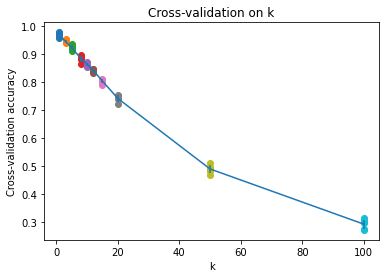

In [46]:
# plot the raw observations
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [54]:
# Based on the cross-validation results above, choose the best value for k,   
# retrain the classifier using all the training data, and test it on the test
# data.
best_k = 1

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_val, k=best_k, num_loops=2)

# Compute and display the accuracy
num_correct = np.sum(y_test_pred == y_val)
num_test = X_val.shape[0]
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' %(num_correct, num_test, accuracy))

Got 481 / 500 correct => accuracy: 0.962000
